In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists
from torch.utils.data import Subset
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:5


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# Define data transformations (you can customize these as needed)
transform = transforms.Compose([
    transforms.Resize((224,224)),  # Resize the images to a common size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])
# Replace 'data_dir' with the path to your dataset folder
data_dir = '/raid/ee-mariyam/maryam/ayush/TiH data'

# Load the dataset
dataset = ImageFolder(root=data_dir, transform=transform)
# Define the percentage split for train, validation, and test
train_percentage = 0.50
val_percentage = 0.25
test_percentage = 0.25

# Calculate the sizes of each split
num_data = len(dataset)
num_train = int(train_percentage * num_data)
num_val = int(val_percentage * num_data)
num_test = num_data - num_train - num_val

# Use random_split to split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [num_train, num_val, num_test], generator=torch.Generator().manual_seed(42))
# Define batch size for data loaders
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=4)


In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor

def to_tensor(img):
    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)

def show_img(img):
    img = np.asarray(img)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

def show_img2(img1, img2, alpha=0.8):
    img1 = np.asarray(img1)
    img2 = np.asarray(img2)
    plt.figure(figsize=(5, 5))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 2:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward

/raid/ee-mariyam/maryam/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import time
from collections import OrderedDict

model = models.densenet121(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
classifier = nn.Sequential(OrderedDict([
                        ('fc1', nn.Linear(1024, 512)),
                        ('relu', nn.ReLU()),
                        ('fc2', nn.Linear(512, 3)),
                        ('output', nn.LogSoftmax(dim=1))
                        ]))

# Replacing the pretrained model classifier with our classifier
model.classifier = classifier
num_classes = 3 # Change this according to your dataset

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Fine-tune the model
device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 10
training_start_time = time.time()
training_loss = []
validation_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        # logits = outputs.logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        # Calculate training accuracy
        _, predicted = torch.max(outputs, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
    train_loss = running_loss / len(train_loader)
    training_loss.append(train_loss)
    train_accuracy = 100 * correct_predictions / total_predictions

    # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy:.2f}%")
    # Validation loop
    model.eval()  # Set the model to evaluation mode
    val_correct_predictions = 0
    val_total_predictions = 0
    val_running_loss = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_total_predictions += val_labels.size(0)
            val_correct_predictions += (val_predicted == val_labels).sum().item()

    val_loss = val_running_loss / len(val_loader)
    validation_loss.append(val_loss)
    val_accuracy = 100 * val_correct_predictions / val_total_predictions
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

/raid/ee-mariyam/maryam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/ee-mariyam/maryam/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 0.8465, Train Accuracy: 74.60%, Val Loss: 0.5704, Val Accuracy: 89.48%
Epoch 2/10, Train Loss: 0.4458, Train Accuracy: 92.26%, Val Loss: 0.3353, Val Accuracy: 92.66%
Epoch 3/10, Train Loss: 0.2857, Train Accuracy: 93.65%, Val Loss: 0.2452, Val Accuracy: 94.44%
Epoch 4/10, Train Loss: 0.2238, Train Accuracy: 95.24%, Val Loss: 0.1876, Val Accuracy: 95.44%
Epoch 5/10, Train Loss: 0.1856, Train Accuracy: 95.93%, Val Loss: 0.1826, Val Accuracy: 96.23%
Epoch 6/10, Train Loss: 0.1539, Train Accuracy: 96.53%, Val Loss: 0.1371, Val Accuracy: 96.63%
Epoch 7/10, Train Loss: 0.1329, Train Accuracy: 95.83%, Val Loss: 0.1225, Val Accuracy: 96.23%
Epoch 8/10, Train Loss: 0.1098, Train Accuracy: 97.62%, Val Loss: 0.1064, Val Accuracy: 97.22%
Epoch 9/10, Train Loss: 0.0969, Train Accuracy: 97.92%, Val Loss: 0.0954, Val Accuracy: 97.62%
Epoch 10/10, Train Loss: 0.0971, Train Accuracy: 97.42%, Val Loss: 0.0990, Val Accuracy: 96.43%
Training finished, took 538.94s


In [6]:
torch.save(model, '/raid/ee-mariyam/maryam/ayush/models/DenseNet_Onion_model.pt')

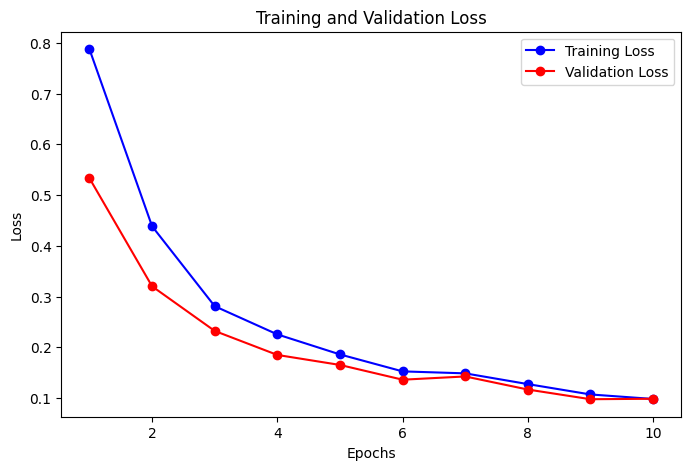

In [6]:
import matplotlib.pyplot as plt

# Define the x-axis (epochs)
epochs = range(1, len(training_loss) + 1)

# Create a figure and plot the training loss and validation loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, training_loss, 'bo-', label='Training Loss')
plt.plot(epochs, validation_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()

In [7]:
model.eval()

correct_predictions = 0
total_predictions = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

test_accuracy = 100 * correct_predictions / total_predictions
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 98.42%


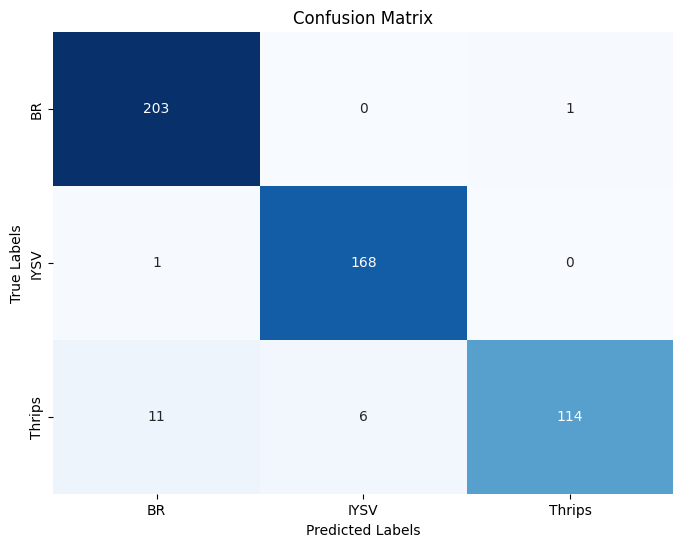

In [8]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:  # Replace 'dataloader' with your data loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Assuming a classification task with class indices
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix as a heatmap
class_names = ["BR", "IYSV", "Thrips"] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


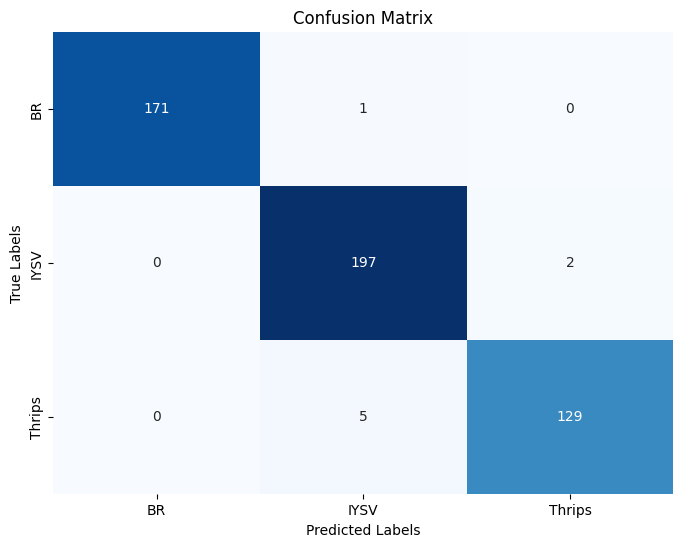

In [9]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:  # Replace 'dataloader' with your data loader
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Assuming a classification task with class indices
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
conf_matrix = confusion_matrix(all_labels, all_predictions)
# Plot the confusion matrix as a heatmap
class_names = ["BR", "IYSV", "Thrips"] 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [10]:
!git clone https://github.com/jacobgil/pytorch-grad-cam.git

fatal: destination path 'pytorch-grad-cam' already exists and is not an empty directory.


In [14]:
import sys

sys.path.append('./pytorch-grad-cam')

In [12]:
!pip install -r pytorch-grad-cam/requirements.txt

In [15]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [16]:
loaded_model_h5=model

In [17]:
# Layer name of each layer, used for deciding which layer to freeze
for name, module in loaded_model_h5.named_modules():
    print(name)

# Decide which layer to freeze


features
features.conv0
features.norm0
features.relu0
features.pool0
features.denseblock1
features.denseblock1.denselayer1
features.denseblock1.denselayer1.norm1
features.denseblock1.denselayer1.relu1
features.denseblock1.denselayer1.conv1
features.denseblock1.denselayer1.norm2
features.denseblock1.denselayer1.relu2
features.denseblock1.denselayer1.conv2
features.denseblock1.denselayer2
features.denseblock1.denselayer2.norm1
features.denseblock1.denselayer2.relu1
features.denseblock1.denselayer2.conv1
features.denseblock1.denselayer2.norm2
features.denseblock1.denselayer2.relu2
features.denseblock1.denselayer2.conv2
features.denseblock1.denselayer3
features.denseblock1.denselayer3.norm1
features.denseblock1.denselayer3.relu1
features.denseblock1.denselayer3.conv1
features.denseblock1.denselayer3.norm2
features.denseblock1.denselayer3.relu2
features.denseblock1.denselayer3.conv2
features.denseblock1.denselayer4
features.denseblock1.denselayer4.norm1
features.denseblock1.denselayer4.rel

In [18]:
freeze_layers = ["features.denseblock4.denselayer16.conv2"]
# Output Layer name for which training is ON
for name, parameter in loaded_model_h5.named_parameters():
  if any(freeze_layer in name for freeze_layer in freeze_layers):
    parameter.requires_grad = True
    print(name)

features.denseblock4.denselayer16.conv2.weight


In [19]:
target_layers = [loaded_model_h5.features.denseblock4.denselayer16.conv2]

In [30]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''

    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.LANCZOS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.

    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]

    imgA = (imgA - 0.485)/(0.229)
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)

    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC

    npImage = np.transpose(npImage, (2,0,1))

    return npImage

torch.Size([1, 3, 224, 224])


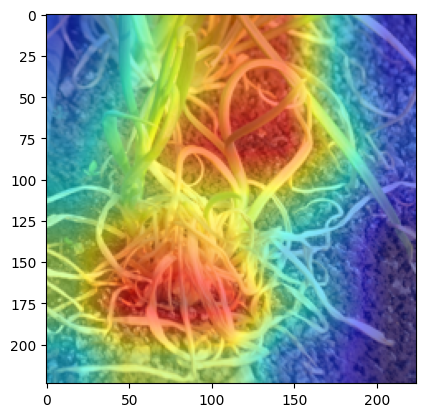

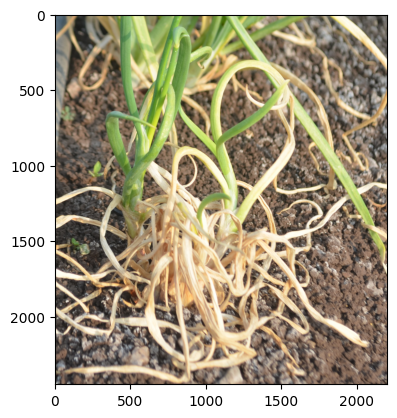

In [32]:
image_path = '/raid/ee-mariyam/maryam/ayush/TiH data/Bulb_Rot/BR E5 P1 E (0070) - 24 Jan.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

torch.Size([1, 3, 224, 224])


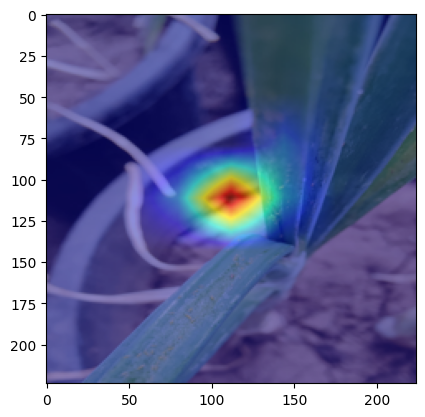

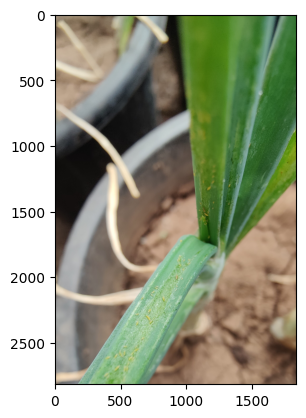

In [33]:
image_path = '/raid/ee-mariyam/maryam/ayush/TiH data/Thrips/TH (I)  IMG20230213121350 (2)  FEB 27.jpg'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

torch.Size([1, 3, 224, 224])


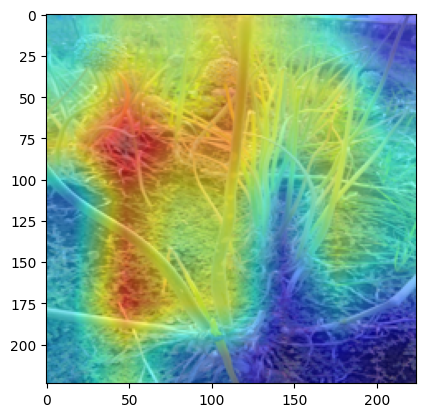

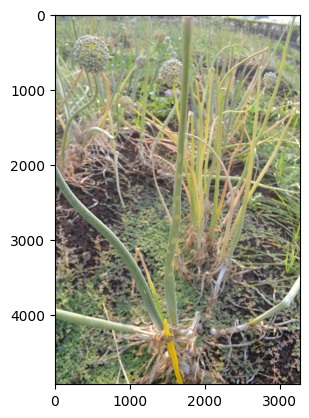

In [36]:
image_path = '/raid/ee-mariyam/maryam/ayush/TiH data/IYSV/IYSV E5 DSC_0016 APR 18.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

torch.Size([1, 3, 224, 224])


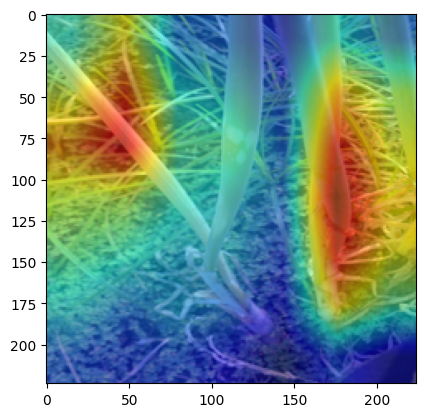

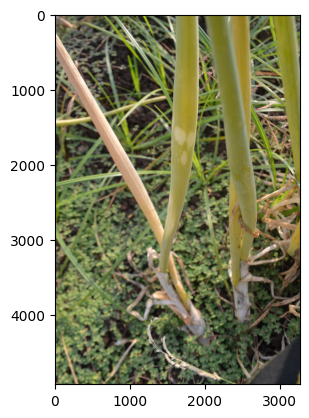

In [37]:
image_path = '/raid/ee-mariyam/maryam/ayush/TiH data/IYSV/IYSV E5 DSC_0006 APR 18.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

torch.Size([1, 3, 224, 224])


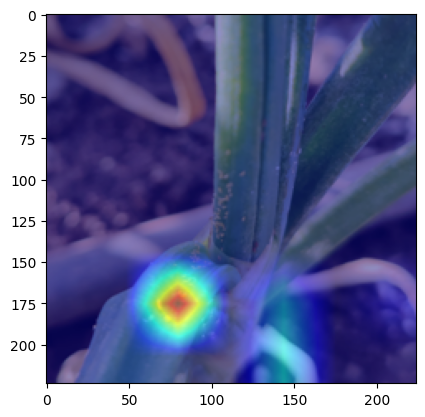

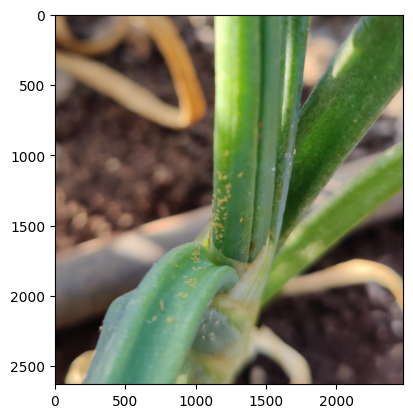

In [38]:
image_path = '/raid/ee-mariyam/maryam/ayush/TiH data/Thrips/TH (I) D2 IMG20230215171735 FEB 14.jpg'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

In [42]:
image_path = '/raid/ee-mariyam/maryam/ayush/TiH data/IYSV/IYSV E5 DSC_0083 APR 21.JPG'
input_tensor = torch.FloatTensor([process_image(Image.open(image_path))])
image = Image.open(image_path)
cam = GradCAM(model=loaded_model_h5, target_layers=target_layers)

# targets = [ClassifierOutputTarget(10)]
torch.set_grad_enabled(True)
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
print(input_tensor.shape)
grayscale_cam = cam(input_tensor=input_tensor)
grayscale_cam = grayscale_cam[0, :]

visualization = show_cam_on_image(np.asarray(Image.open(image_path).resize((224, 224)))/255., grayscale_cam, use_rgb=True)
plt.figure()
plt.imshow(visualization)
plt.figure()
plt.imshow(image)

ImportError: cannot import name 'TiffImagePlugin' from 'PIL' (/raid/ee-mariyam/maryam/.local/lib/python3.8/site-packages/PIL/__init__.py)